In [102]:
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt

from ud_sac import UDSAC, rollout, sample_episode, train
from core import MeanController, Episode

In [147]:
def plot_agent_perf(env, agent, test_episodes=10):
    desired_returns = np.linspace(10, 195, 50)
    
    actual_returns = [[rollout(env, agent, dr, dr)[0] for _ in range(test_episodes)] for dr in desired_returns]
    actual_returns = np.stack(actual_returns)
    
    actual_means, actual_stds = actual_returns.mean(axis=1), actual_returns.std(axis=1)
    
    plt.figure(figsize=(12, 8))
    plt.plot(desired_returns, actual_means);
    plt.fill_between(desired_returns, actual_means - actual_stds, actual_means + actual_stds)
    plt.xlabel("Desired return")
    plt.ylabel("Actual return")
    plt.title("CartPole-v0");

In [148]:
agent = torch.load("udsac_test.pt", map_location='cpu')
env = gym.make("CartPole-v0")

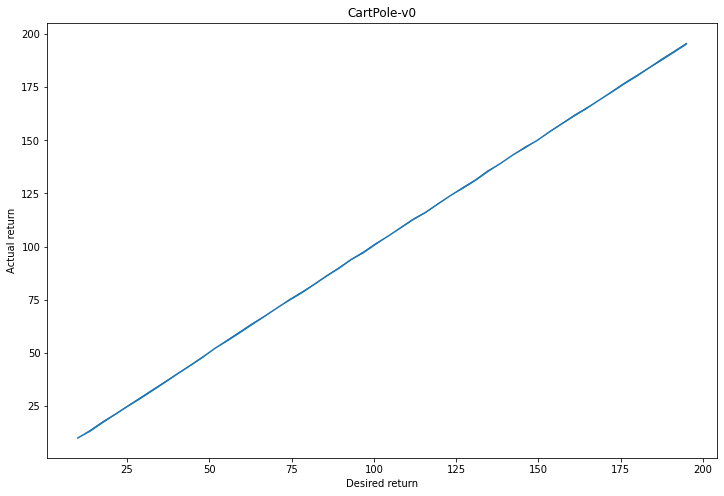

In [149]:
plot_agent_perf(env, agent)

In [120]:
desired_returns = np.linspace(10, 195, 100)
actual_returns = [rollout(env, agent, dr, dr)[0] for dr in desired_returns]

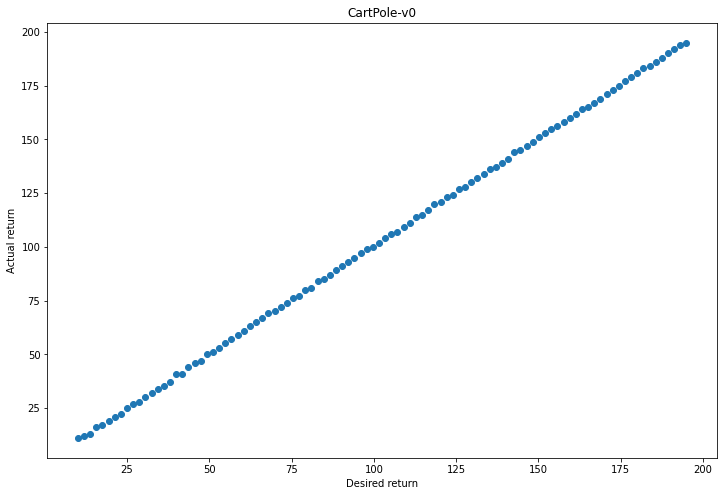

In [121]:
plt.figure(figsize=(12, 8))
plt.scatter(desired_returns, actual_returns);
plt.xlabel("Desired return")
plt.ylabel("Actual return")
plt.title("CartPole-v0");